# Seismic Sources in openquake.hazardlib

In [1]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from openquake.hazardlib.source import PointSource, AreaSource, SimpleFaultSource, ComplexFaultSource, CharacteristicFaultSource
from openquake.hazardlib.mfd import TruncatedGRMFD, EvenlyDiscretizedMFD
from openquake.hazardlib.scalerel import WC1994
from openquake.hazardlib.geo import Point, NodalPlane, Polygon, Line, ComplexFaultSurface
from openquake.hazardlib.geo.surface import PlanarSurface
from openquake.hazardlib.pmf import PMF
from openquake.hazardlib.tom import PoissonTOM

import numpy
from matplotlib import pyplot
from matplotlib import collections
from mpl_toolkits.basemap import Basemap

In [3]:
def get_map_projection(src):
    """
    Return map projection specific to source.
    """
    # extract rupture enclosing polygon (considering a buffer of 10 km)
    rup_poly = src.get_rupture_enclosing_polygon(10.)
    min_lon = numpy.min(rup_poly.lons)
    max_lon = numpy.max(rup_poly.lons)
    min_lat = numpy.min(rup_poly.lats)
    max_lat = numpy.max(rup_poly.lats)
    
    # create map projection
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat,
                llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l')

    return min_lon, max_lon, min_lat, max_lat, m
    

In [4]:
def get_planar_surface_boundary(surf):
    """
    Return coordinates of planar surface boundary
    """
    boundary_lons = numpy.array(
        [surf.top_left.longitude, surf.top_right.longitude,
         surf.bottom_right.longitude, surf.bottom_left.longitude, surf.top_left.longitude]
    )
    boundary_lats = numpy.array(
        [surf.top_left.latitude, surf.top_right.latitude,
         surf.bottom_right.latitude, surf.bottom_left.latitude, surf.top_left.latitude]
    )
    
    return boundary_lons, boundary_lats

In [5]:
def get_mesh_boundary(mesh):
    """
    Return coordinates of mesh boundary
    """
    boundary_lons = numpy.concatenate((mesh.lons[0, :], mesh.lons[1:, -1], mesh.lons[-1,:-1][::-1], mesh.lons[:-1, 0][::-1]))
    boundary_lats = numpy.concatenate((mesh.lats[0, :], mesh.lats[1:, -1], mesh.lats[-1,:-1][::-1], mesh.lats[:-1, 0][::-1]))
    
    return boundary_lons, boundary_lats

# Point Source

In [6]:
# define Point Source
src = PointSource(
    source_id='1',
    name='point',
    tectonic_region_type='Active Shallow Crust',
    mfd=TruncatedGRMFD(min_mag=5., max_mag=6.5, bin_width=0.2, a_val=0.01, b_val=0.98),
    rupture_mesh_spacing=2.,
    magnitude_scaling_relationship=WC1994(),
    rupture_aspect_ratio=1.,
    temporal_occurrence_model=PoissonTOM(50.),
    upper_seismogenic_depth=2.,
    lower_seismogenic_depth=12.,
    location=Point(9.1500, 45.1833),
    nodal_plane_distribution=PMF([(0.5, NodalPlane(strike=45, dip=50, rake=0)), (0.5, NodalPlane(strike=135, dip=50, rake=0))]),
    hypocenter_distribution=PMF([(1, 7.)])
)

In [7]:
# loop over ruptures, extract rupture surface boundary and magnitude
min_lon, max_lon, min_lat, max_lat, m = get_map_projection(src)

boundaries = []
mags = []
for rup in src.iter_ruptures():
    surf = rup.surface
    mag = rup.mag

    boundary_lons, boundary_lats = get_planar_surface_boundary(surf)
    xx, yy = m(boundary_lons, boundary_lats)
    boundaries.append([(x, y) for x, y in zip(xx, yy)])
    mags.append(mag)

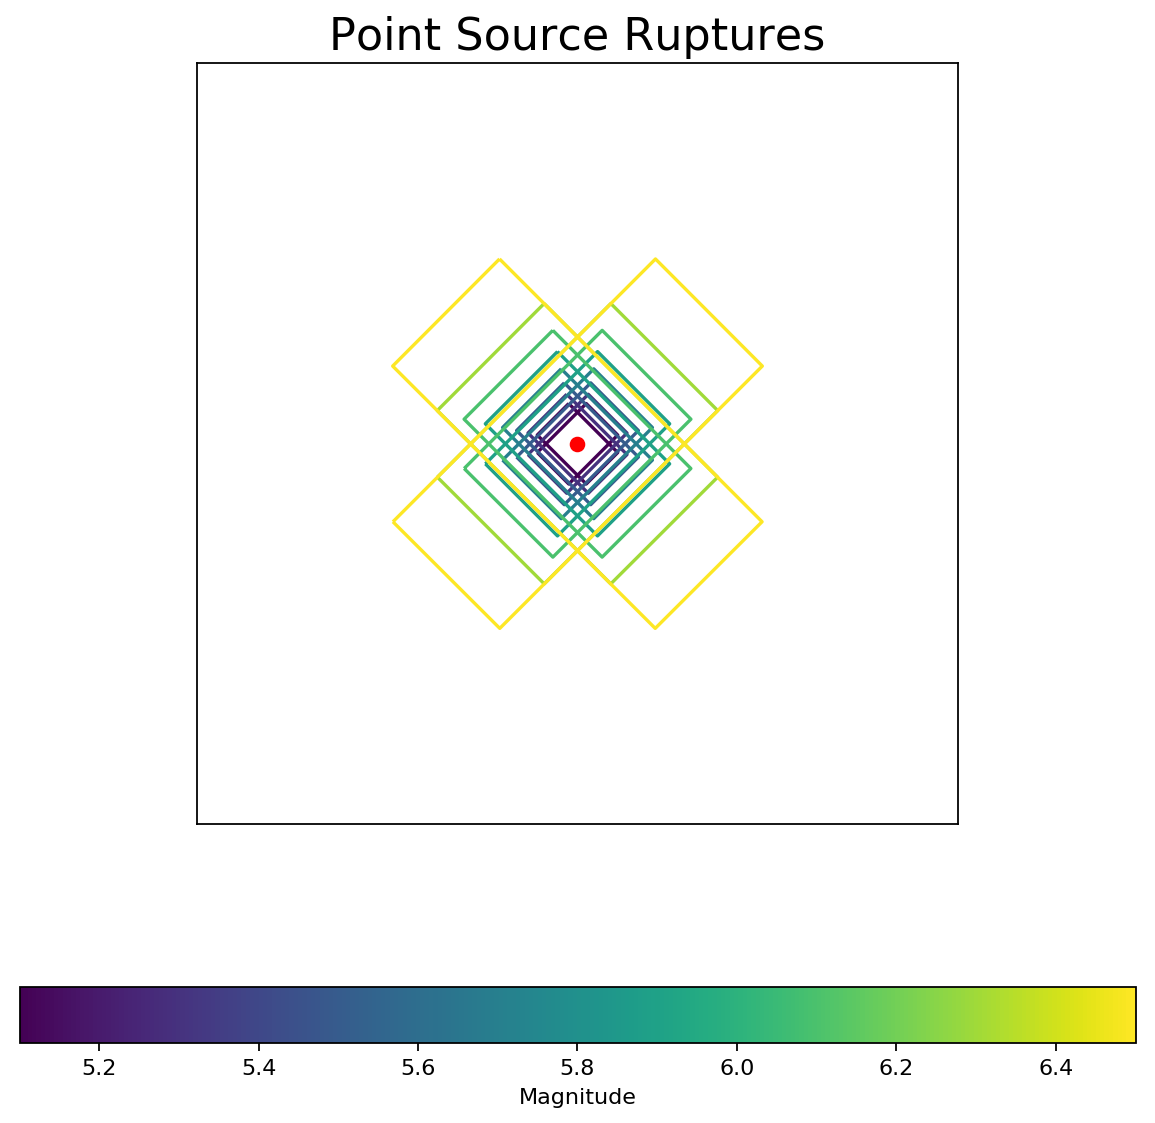

In [8]:
# plot rupturs. Color proportional to magnitude
fig1 = pyplot.figure(figsize=(9, 9), dpi=160)

# m.drawparallels(numpy.arange(min_lat, max_lat, 0.1), labels=[True, False, False, True])
# m.drawmeridians(numpy.arange(min_lon, max_lon, 0.1), labels=[True, False, False, True])
m.drawcoastlines()
m.drawcountries()

x, y = m(src.location.longitude, src.location.latitude)
m.plot(y, y, marker='o', color='red')

bounds = collections.LineCollection(boundaries)
bounds.set_array(numpy.array(mags))
pyplot.gca().add_collection(bounds)

cb = pyplot.colorbar(bounds, orientation='horizontal')
cb.set_label('Magnitude')
pyplot.title('Point Source Ruptures', fontsize=20)

# Area Source

In [9]:
# define area source
src = AreaSource(
    source_id='1',
    name='area',
    tectonic_region_type='Active Shallow Crust',
    mfd=TruncatedGRMFD(min_mag=5., max_mag=6.5, bin_width=0.2, a_val=3.45, b_val=0.98),
    rupture_mesh_spacing=2.,
    magnitude_scaling_relationship=WC1994(),
    rupture_aspect_ratio=1.,
    temporal_occurrence_model=PoissonTOM(50.),
    upper_seismogenic_depth=2.,
    lower_seismogenic_depth=12.,
    nodal_plane_distribution=PMF([(1, NodalPlane(strike=45, dip=30, rake=0))]),
    hypocenter_distribution=PMF([(1, 7.)]),
    polygon=Polygon([Point(133.5, -22.5), Point(133.5, -23.0), Point(130.75, -23.75), Point(130.75, -24.5),
                     Point(133.5, -26.0), Point(133.5, -27.0), Point(130.75, -27.0), Point(128.977, -25.065),
                     Point(128.425, -23.436), Point(126.082, -23.233), Point(125.669, -22.351), Point(125.4, -20.5),
                     Point(125.75, -20.25), Point(126.7, -21.25), Point(128.5, -21.25), Point(129.25, -20.6),
                     Point(130.0, -20.6), Point(130.9, -22.25), Point(133.0, -22.0), Point(133.5, -22.5)]),
    area_discretization=20.
)

In [10]:
# loop over ruptures, extract rupture surface boundary and magnitude
min_lon, max_lon, min_lat, max_lat, m = get_map_projection(src)

boundaries = []
mags = []
for rup in src.iter_ruptures():
    surf = rup.surface
    mag = rup.mag

    boundary_lons, boundary_lats = get_planar_surface_boundary(surf)
    xx, yy = m(boundary_lons, boundary_lats)
    boundaries.append([(x, y) for x, y in zip(xx, yy)])
    mags.append(mag)

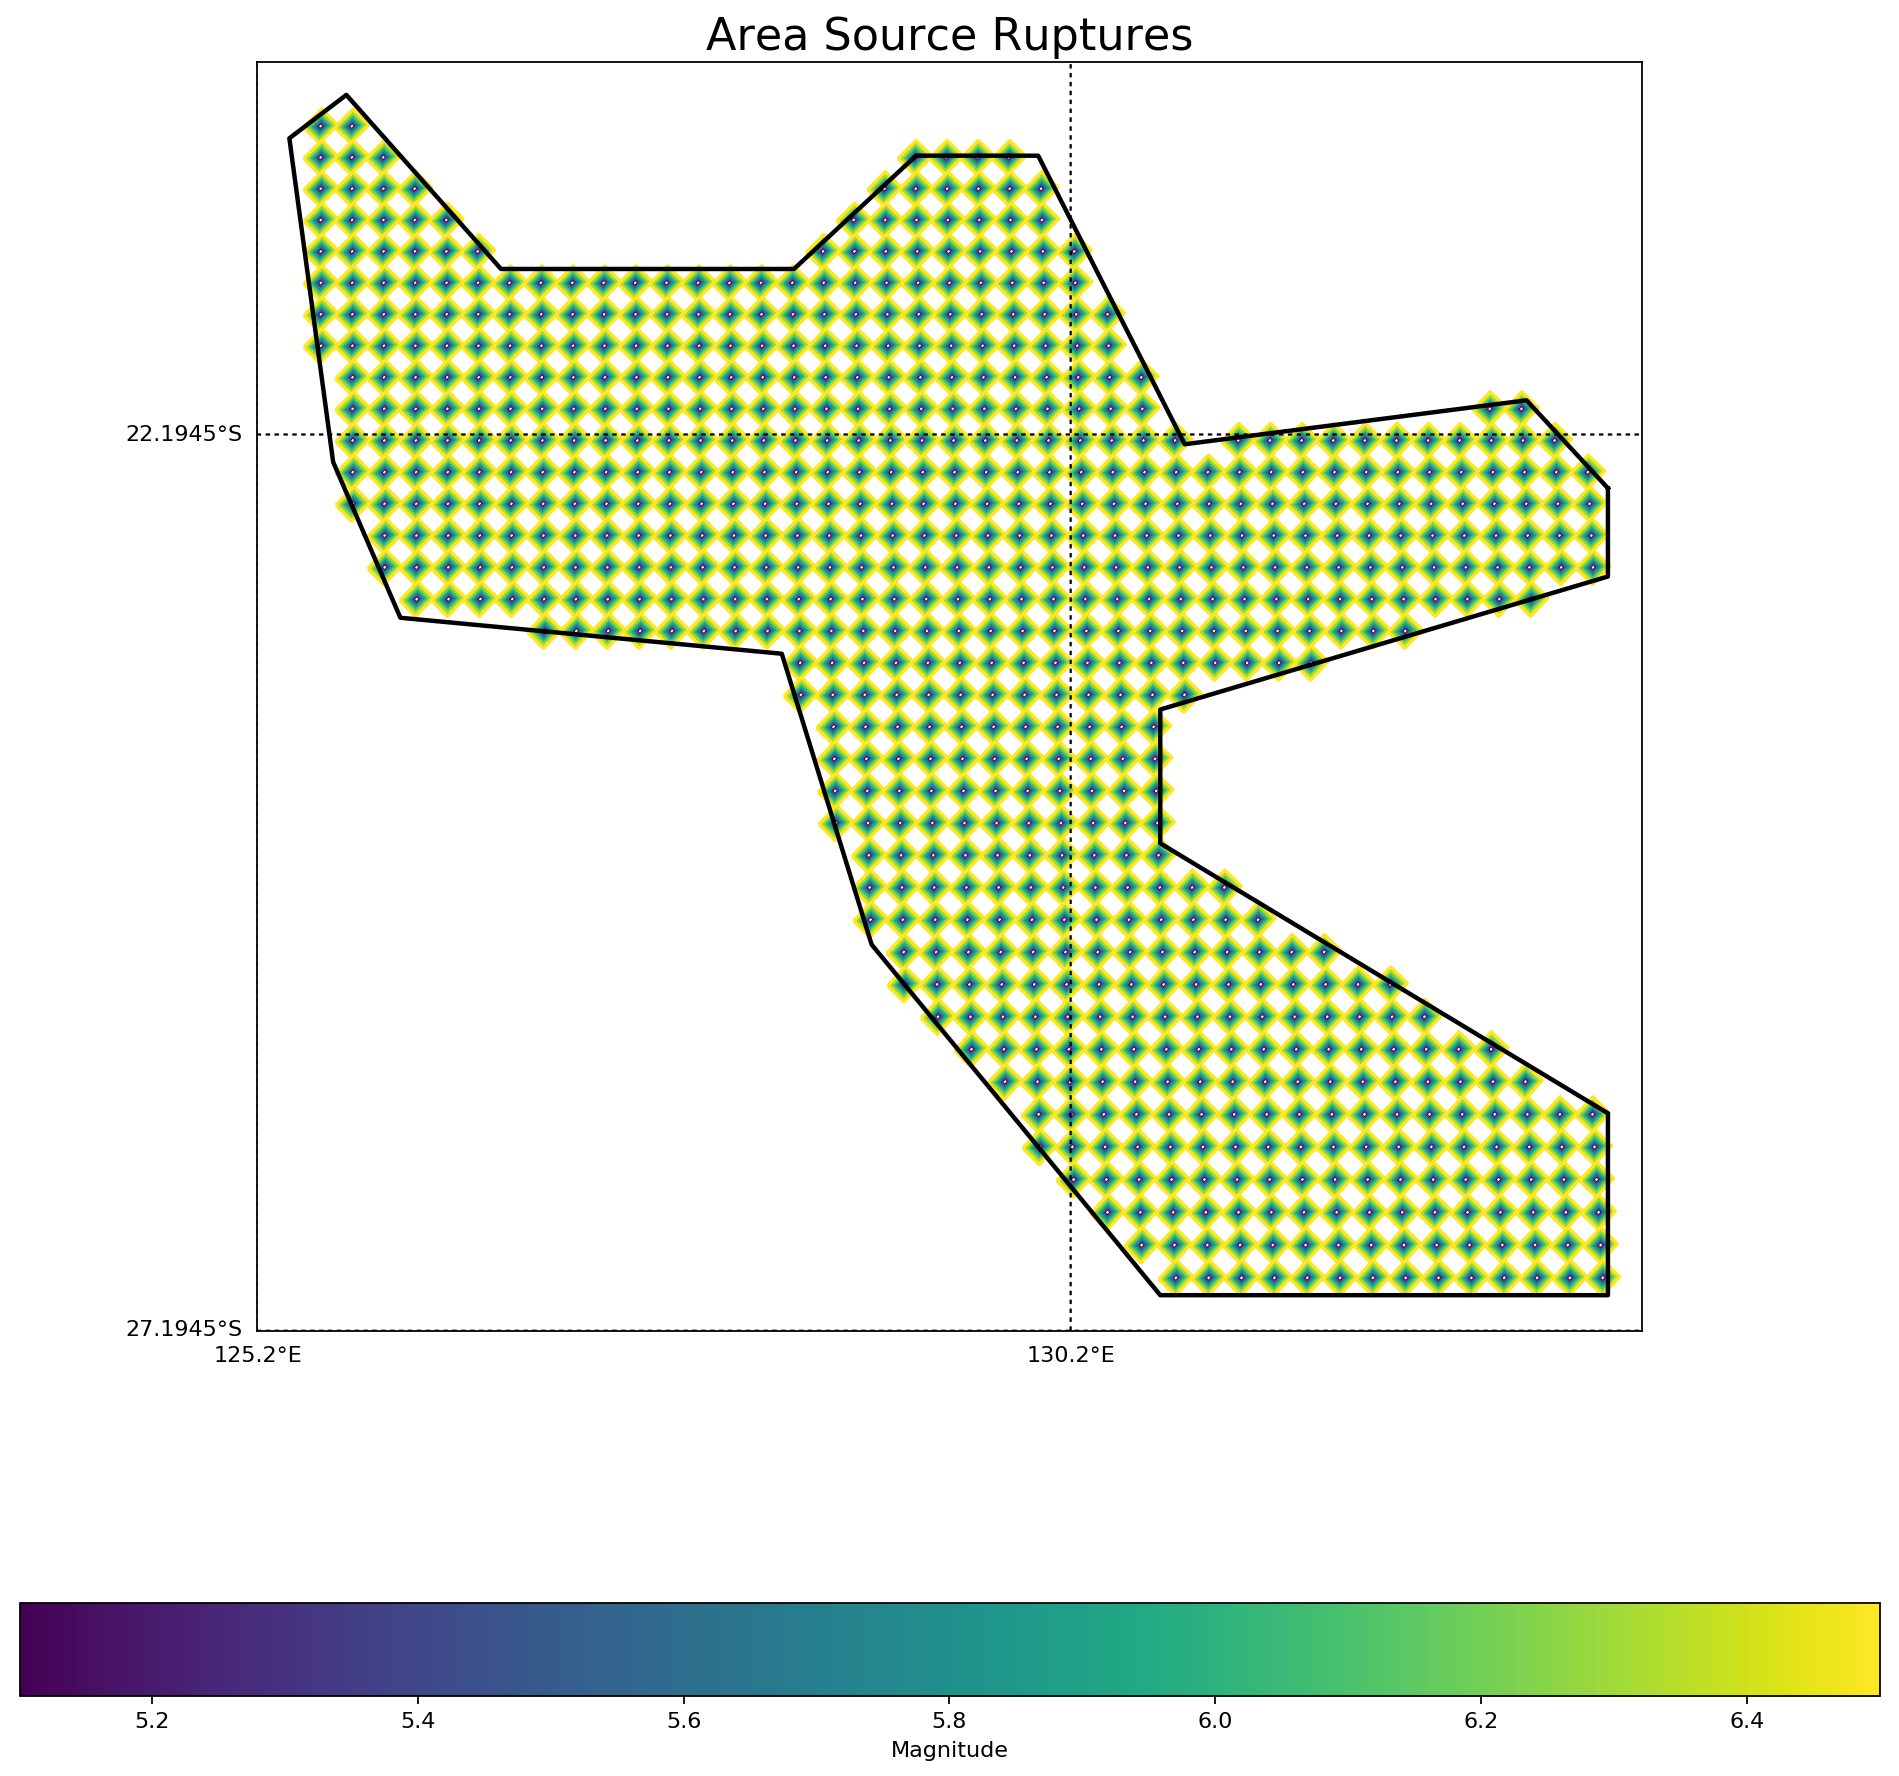

In [11]:
# plot ruptures. Color proportional to magnitude
fig1 = pyplot.figure(figsize=(15, 15), dpi=160)

m.drawparallels(numpy.arange(min_lat, max_lat, 5.), labels=[True, False, False, True])
m.drawmeridians(numpy.arange(min_lon, max_lon, 5.), labels=[True, False, False, True])
m.drawcoastlines()
m.drawcountries()

# plot area source boundary
x, y = m(src.polygon.lons, src.polygon.lats)
m.plot(x, y, linewidth=2, color='black')

bounds = collections.LineCollection(boundaries)
bounds.set_array(numpy.array(mags))
pyplot.gca().add_collection(bounds)

cb = pyplot.colorbar(bounds, orientation='horizontal')
cb.set_label('Magnitude')
pyplot.title('Area Source Ruptures', fontsize=20)

# SimpleFaultSource

In [12]:
src = SimpleFaultSource(
    source_id='1',
    name='simple fault',
    tectonic_region_type='active shallow crust',
    mfd=TruncatedGRMFD(min_mag=5., max_mag=6.5, bin_width=0.2, a_val=3.45, b_val=0.98),
    rupture_mesh_spacing=2.,
    magnitude_scaling_relationship=WC1994(),
    rupture_aspect_ratio=1.,
    temporal_occurrence_model=PoissonTOM(50.),
    upper_seismogenic_depth=2.,
    lower_seismogenic_depth=7.,
    fault_trace=Line([Point(9.21602706445, 45.1555287905), Point(9.25645636929, 45.1877167851),
                      Point(9.29688464252, 45.2199047798), Point(9.35715705075, 45.2398017764),
                      Point(9.42902686305, 45.2401237764), Point(9.47246500782, 45.2381597767),
                      Point(9.51590215304, 45.236194777), Point(9.56736930079, 45.2307927779),
                      Point(9.61883544823, 45.2253897788), Point(9.67030259419, 45.2199877797),
                      Point(9.72270625188, 45.2033947825), Point(9.77510990175, 45.1868007853),
                      Point(9.83238881096, 45.1680237884), Point(9.88966771001, 45.1492457915),
                      Point(9.94694559775, 45.1304687947), Point(10.0042244753, 45.1116907978)]),
    dip=30.,
    rake=90.
)

In [13]:
# loop over ruptures, extract rupture surface boundary and magnitude
min_lon, max_lon, min_lat, max_lat, m = get_map_projection(src)

boundaries = []
mags = []
for rup in src.iter_ruptures():
    surf = rup.surface
    mesh = surf.get_mesh()
    mag = rup.mag

    boundary_lons, boundary_lats = get_mesh_boundary(mesh)
    xx, yy = m(boundary_lons, boundary_lats)

    boundaries.append([(x, y) for x, y in zip(xx, yy)])
    mags.append(mag)

boundaries = numpy.array(boundaries)
mags = numpy.array(mags)

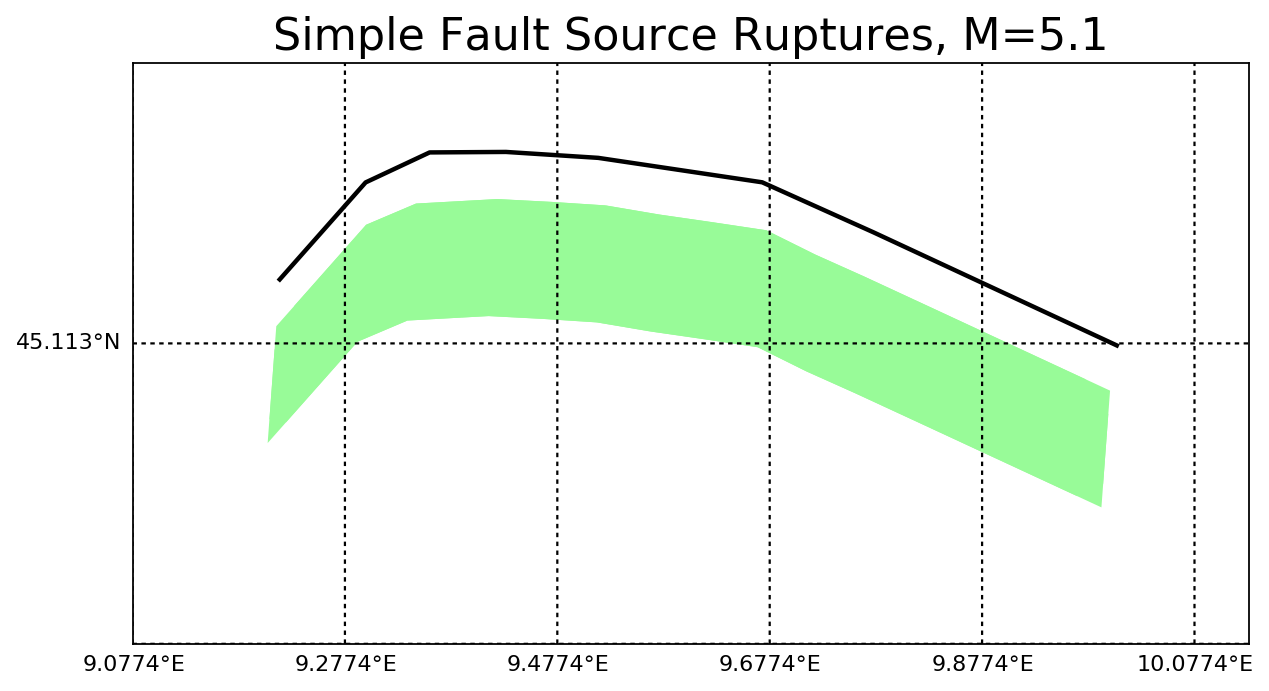

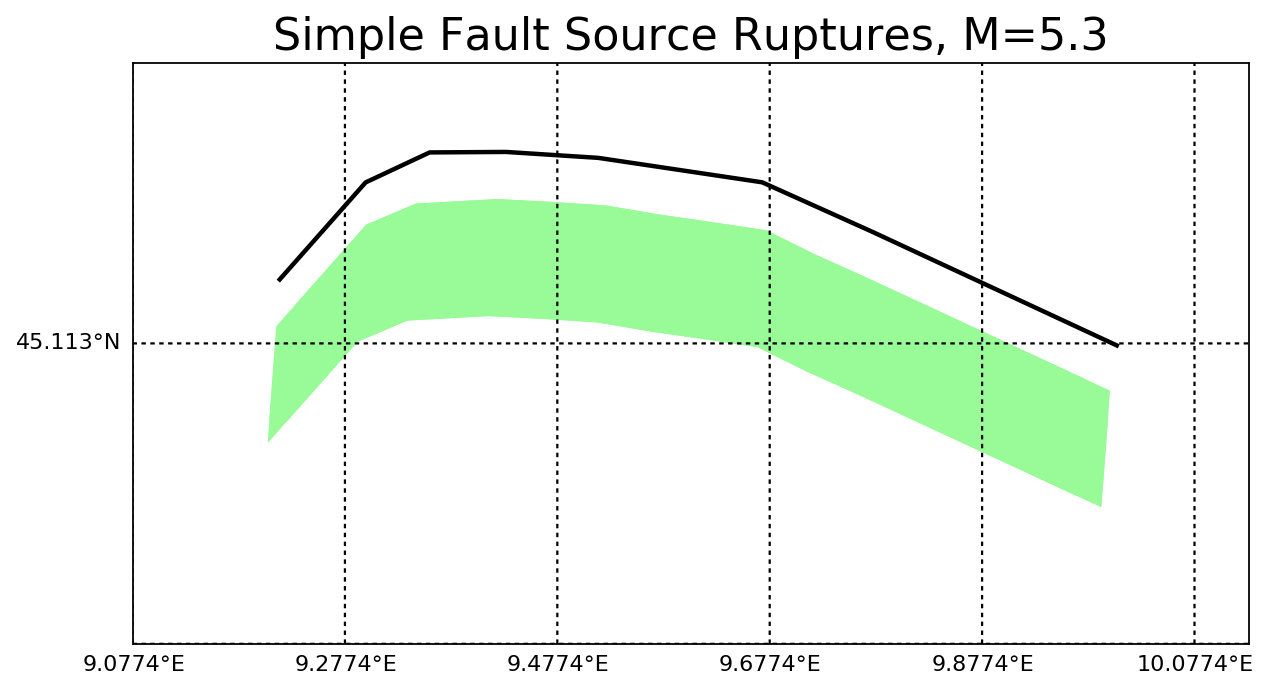

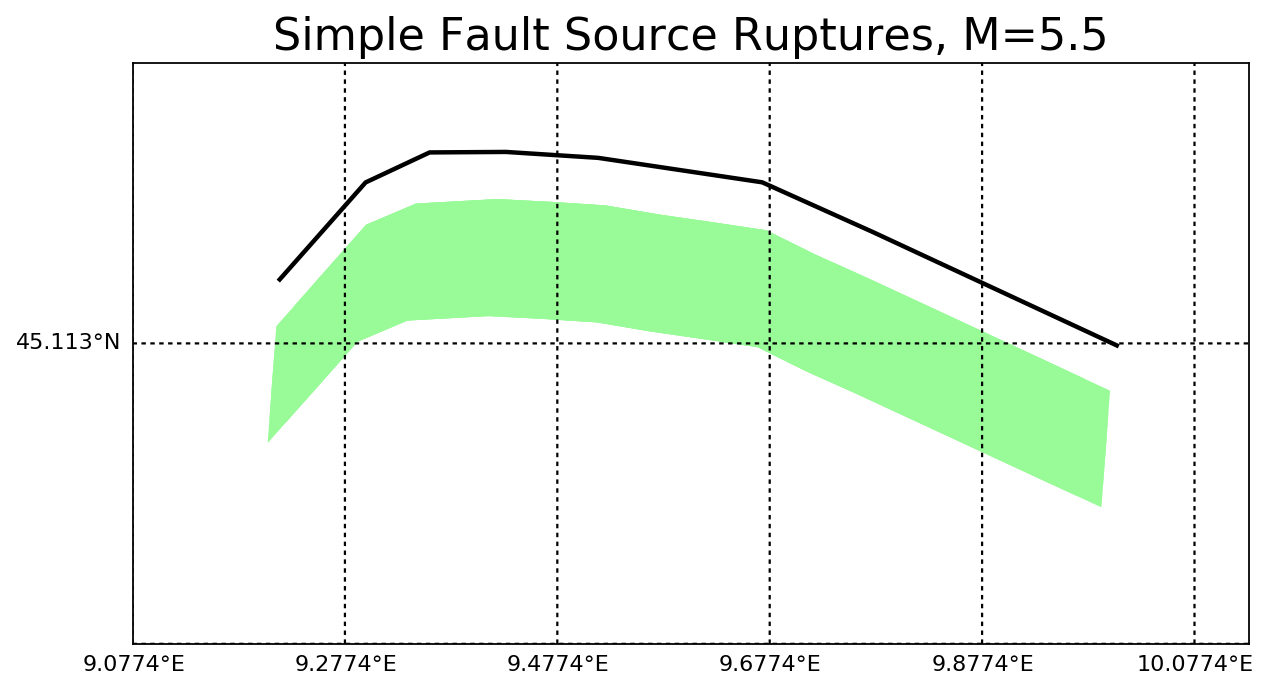

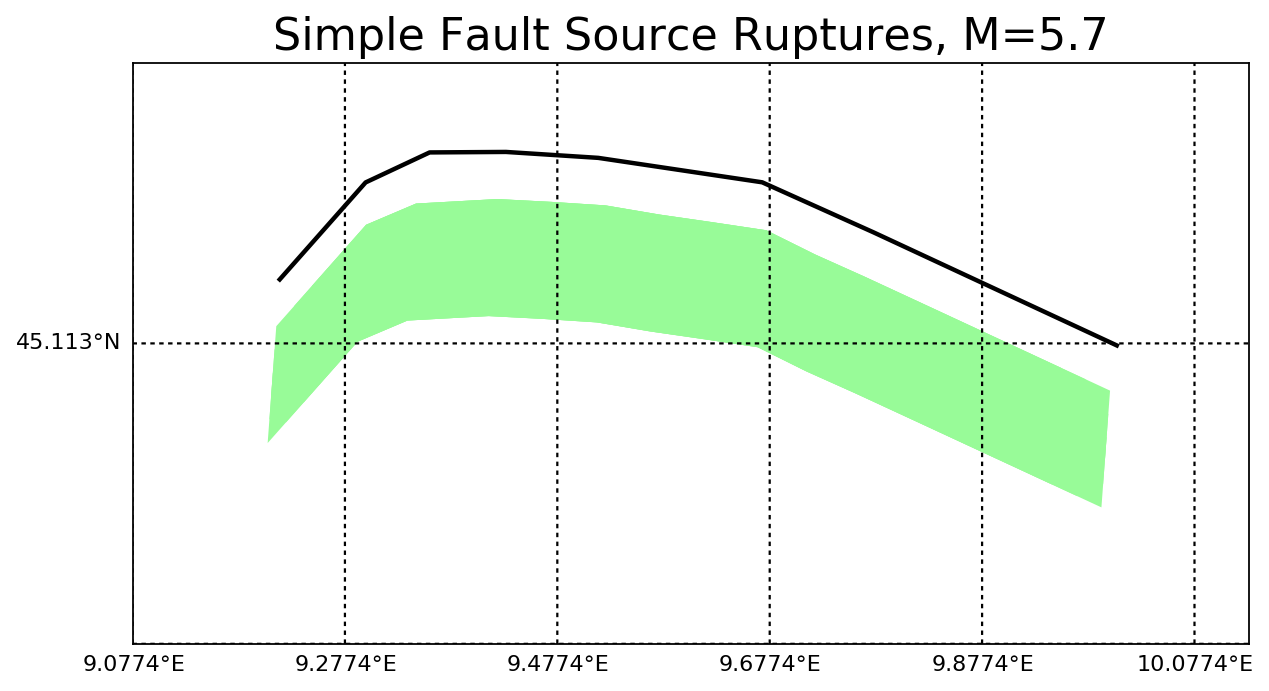

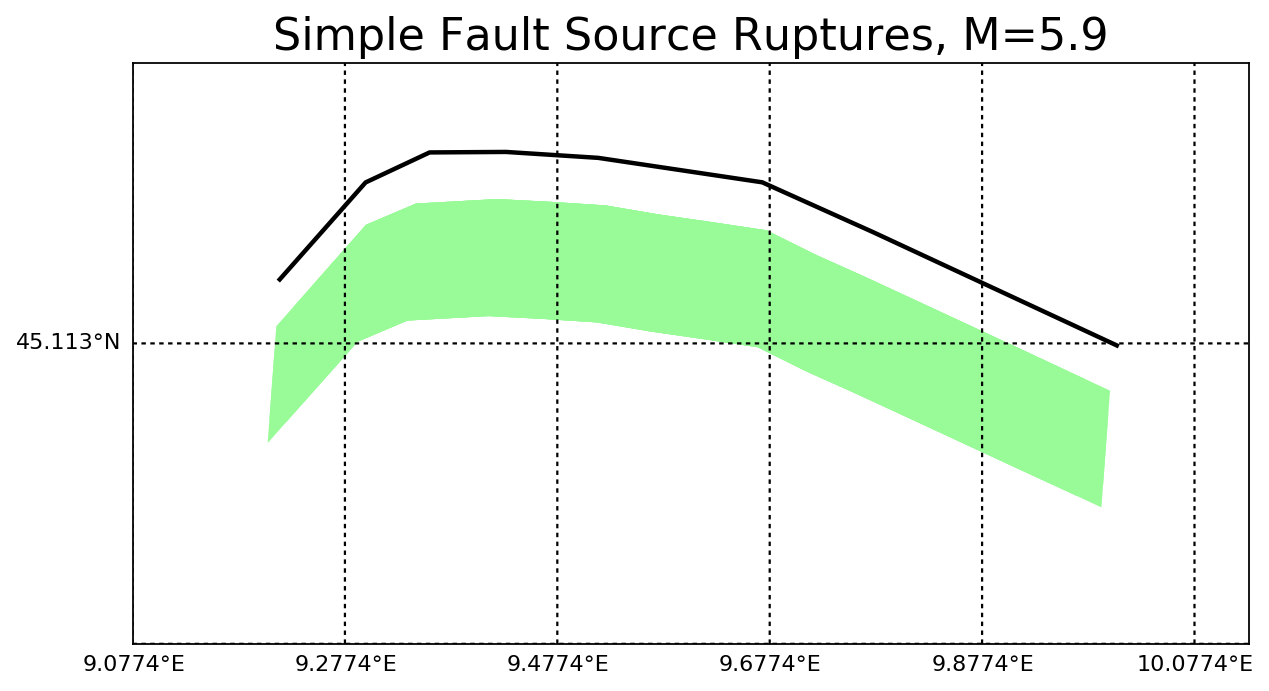

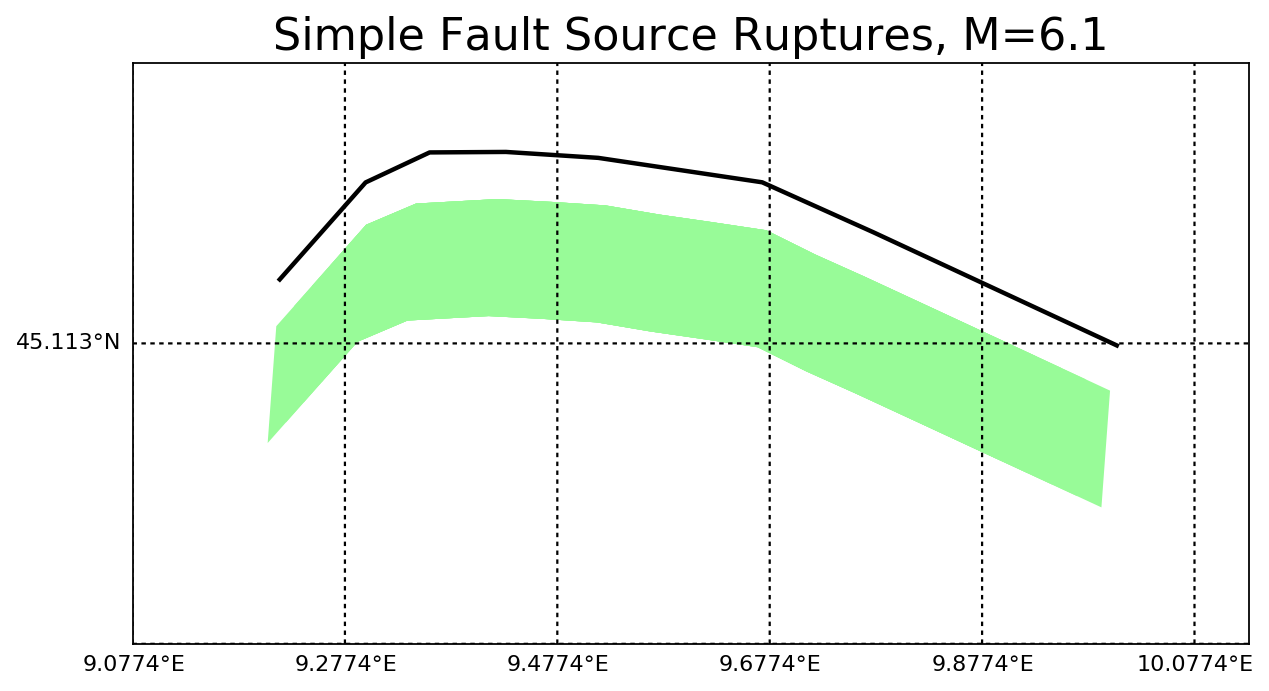

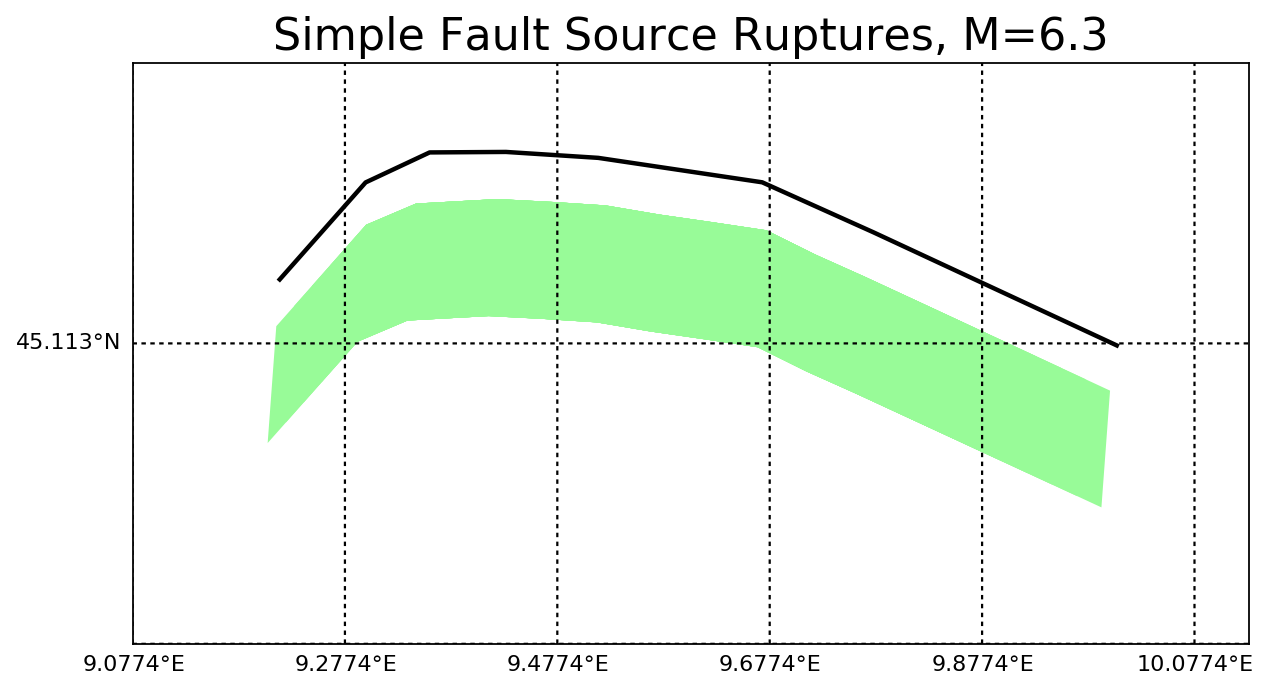

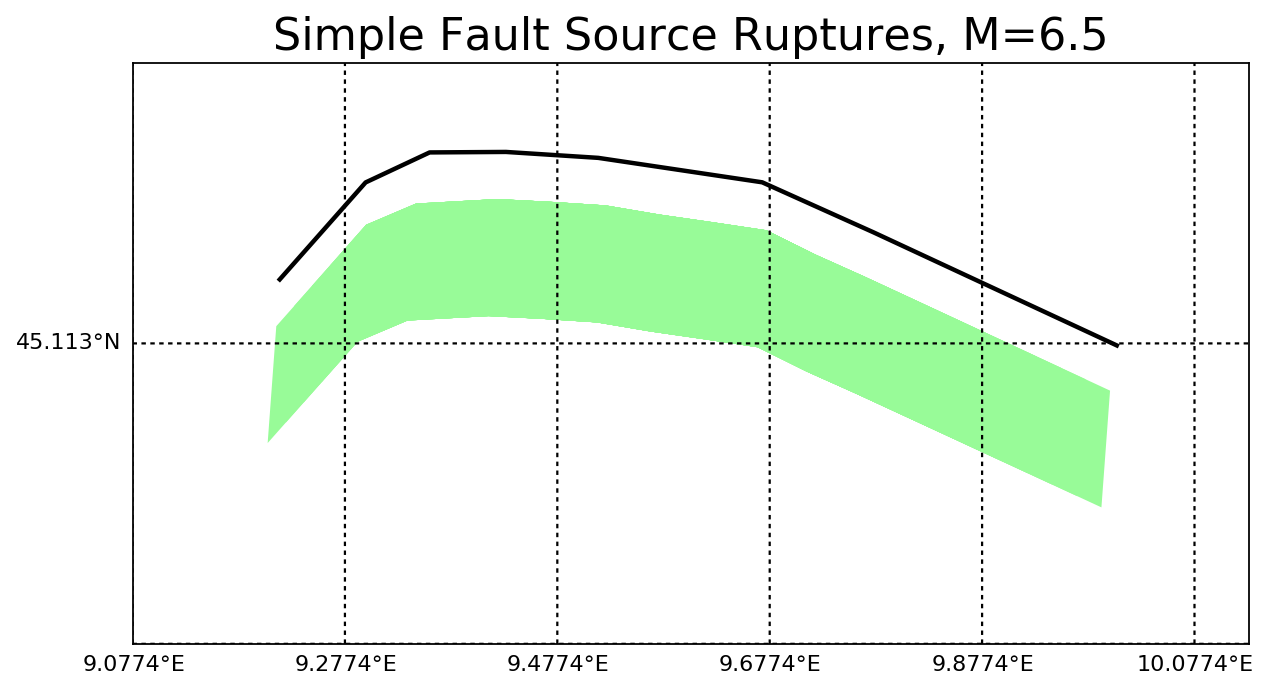

In [14]:
# plot ruptures.
unique_mags = numpy.unique(mags)
for mag in unique_mags:
    idx = mags == mag

    fig = pyplot.figure(figsize=(9, 9), dpi=160)
    
    m.drawparallels(numpy.arange(min_lat, max_lat, 0.2), labels=[True, False, False, True])
    m.drawmeridians(numpy.arange(min_lon, max_lon, 0.2), labels=[True, False, False, True])
    m.drawcoastlines()
    m.drawcountries()
    
    # extract and plot fault trace
    lons = [p.longitude for p in src.fault_trace.points]
    lats = [p.latitude for p in src.fault_trace.points]
    x, y = m(lons, lats)
    m.plot(x, y, linewidth=2, color='black')
    
    bounds = collections.PolyCollection(boundaries[idx], facecolors='palegreen')
    pyplot.gca().add_collection(bounds)
    
    pyplot.title('Simple Fault Source Ruptures, M=%s' % mag, fontsize=20)

# Complex Fault Source

In [15]:
top_edge = Line([Point(144.069555556, 39.7059999996, 9.202), Point(143.987666642, 39.0726212093, 9.202),
                 Point(143.844804987, 38.4446225095, 9.202), Point(143.715121187, 37.8147879271, 9.202),
                 Point(143.452451355, 37.2149977193, 9.202), Point(143.086155668, 36.6503300815, 9.202),
                 Point(142.589773574, 36.1569466634, 9.202), Point(142.202909091, 35.606, 9.202)])

bottom_edge = Line([Point(142.0450625, 39.7059999997, 48.202), Point(141.970993342, 39.1530522533, 48.202),
                    Point(141.893707006, 38.6004781864, 48.202), Point(141.734990146, 38.0590949727, 48.202),
                    Point(141.52384879, 37.5292617122, 48.202), Point(141.2114751, 37.0322180634, 48.202),
                    Point(140.900140283, 36.5353773475, 48.202), Point(140.697696296, 36.006, 48.202)])
edges = [top_edge, bottom_edge]

src = ComplexFaultSource(
    source_id='1', 
    name='Complex Fault',
    tectonic_region_type='Subduction Interface',
    mfd=EvenlyDiscretizedMFD(bin_width=0.1, min_mag=7.7, occurrence_rates=[0.004845]),
    rupture_mesh_spacing=10.,
    magnitude_scaling_relationship=WC1994(),
    rupture_aspect_ratio=1.,
    temporal_occurrence_model=PoissonTOM(50.),
    edges=edges,
    rake=90.
)

In [16]:
# loop over ruptures, extract rupture surface boundary and magnitude
min_lon, max_lon, min_lat, max_lat, m = get_map_projection(src)

boundaries = []
mags = []
for rup in src.iter_ruptures():
    surf = rup.surface
    mesh = surf.get_mesh()
    mag = rup.mag

    boundary_lons, boundary_lats = get_mesh_boundary(mesh)
    xx, yy = m(boundary_lons, boundary_lats)

    boundaries.append([(x, y) for x, y in zip(xx, yy)])
    mags.append(mag)
boundaries = numpy.array(boundaries)
mags = numpy.array(mags)

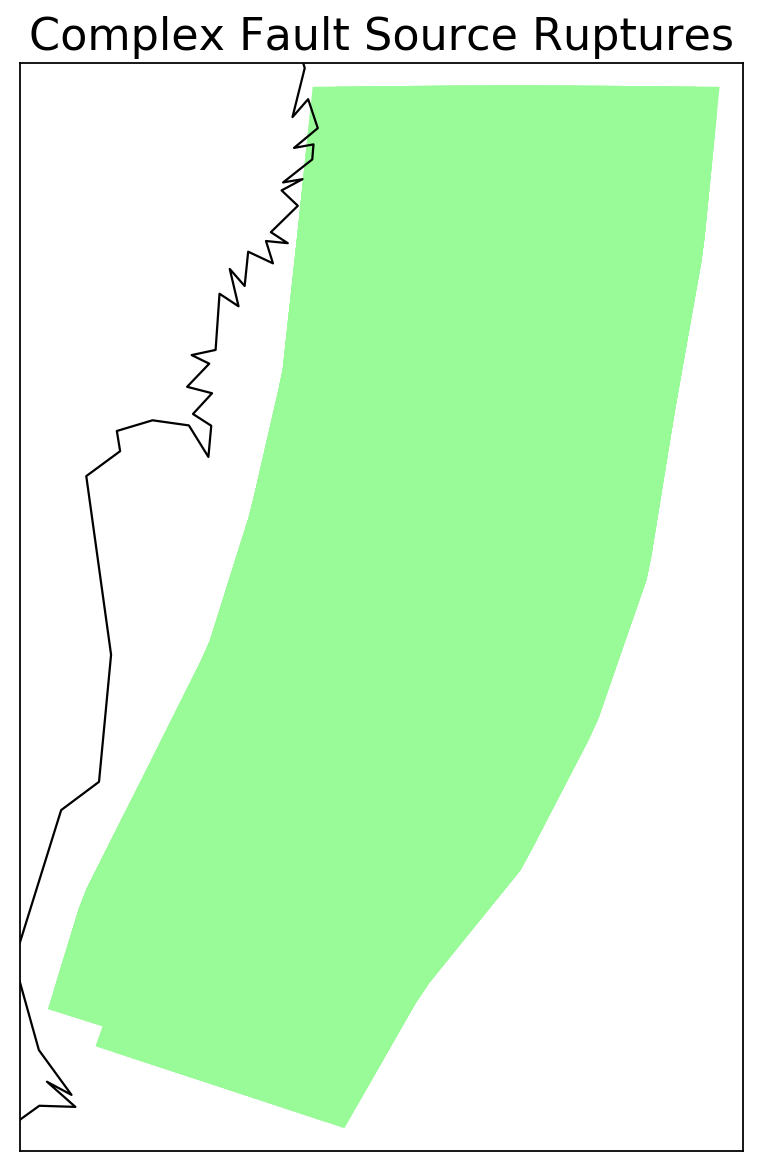

In [17]:
# plot ruptures.
fig = pyplot.figure(figsize=(9, 9), dpi=160)

# m.drawparallels(numpy.arange(min_lat, max_lat, 1.), labels=[True, False, False, True])
# m.drawmeridians(numpy.arange(min_lon, max_lon, 1.), labels=[True, False, False, True])
m.drawcoastlines()
m.drawcountries()

bounds = collections.PolyCollection(boundaries, facecolors='palegreen')
pyplot.gca().add_collection(bounds)

pyplot.title('Complex Fault Source Ruptures', fontsize=20)

# Characteristic Fault Source

In [18]:
src = CharacteristicFaultSource(
    source_id='1',
    name='characteristic',
    tectonic_region_type='active shallow crust',
    mfd=EvenlyDiscretizedMFD(bin_width=0.1, min_mag=8.7, occurrence_rates=[0.004845, 0.004845]),
    temporal_occurrence_model=PoissonTOM(50.),
    surface=ComplexFaultSurface.from_fault_data(edges=edges, mesh_spacing=10.),
    rake=90.
)

In [19]:
# loop over ruptures, extract rupture surface boundary and magnitude
min_lon, max_lon, min_lat, max_lat, m = get_map_projection(src)

boundaries = []
mags = []
for rup in src.iter_ruptures():
    surf = rup.surface
    mesh = surf.get_mesh()
    mag = rup.mag

    boundary_lons, boundary_lats = get_mesh_boundary(mesh)
    xx, yy = m(boundary_lons, boundary_lats)

    boundaries.append([(x, y) for x, y in zip(xx, yy)])
    mags.append(mag)
boundaries = numpy.array(boundaries)
mags = numpy.array(mags)

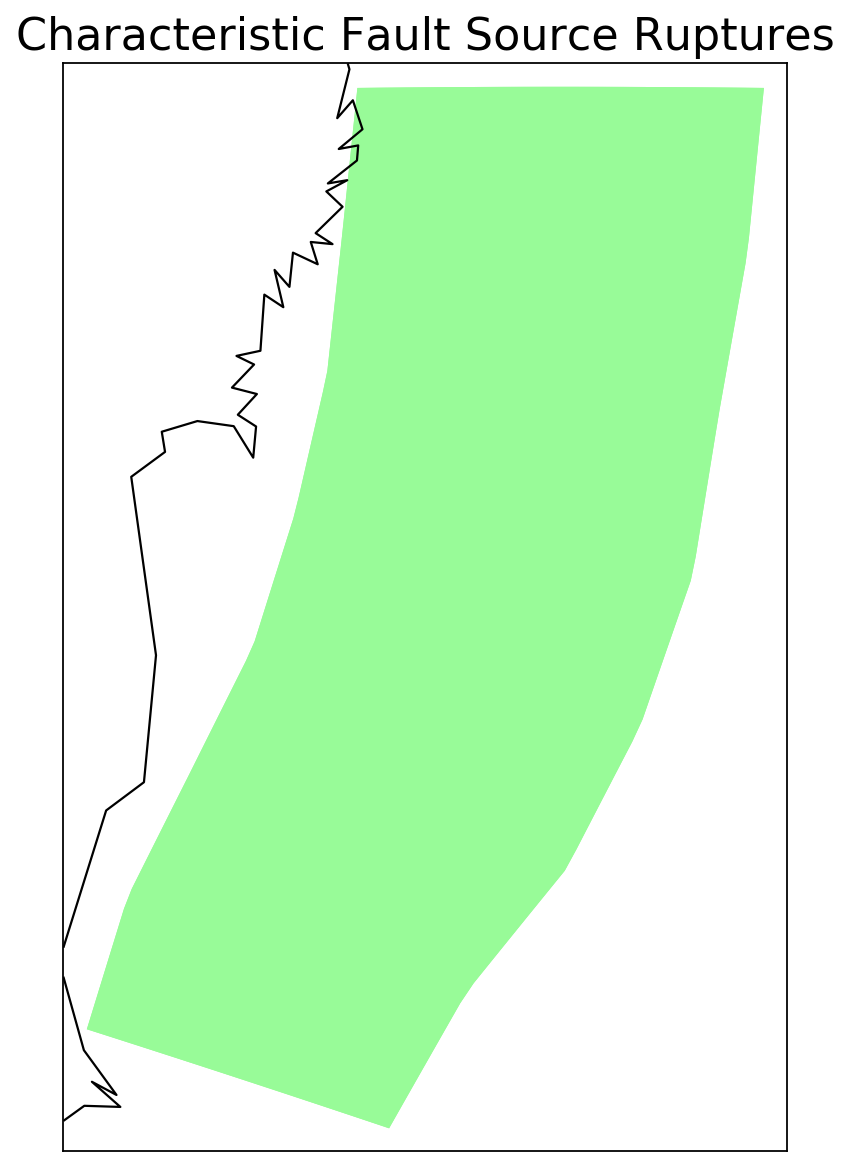

In [20]:
# plot ruptures.
fig = pyplot.figure(figsize=(9, 9), dpi=160)

#m.drawparallels(numpy.arange(min_lat, max_lat, 1.), labels=[True, False, False, True])
#m.drawmeridians(numpy.arange(min_lon, max_lon, 1.), labels=[True, False, False, True])
m.drawcoastlines()
m.drawcountries()

bounds = collections.PolyCollection(boundaries, facecolors='palegreen')
pyplot.gca().add_collection(bounds)

pyplot.title('Characteristic Fault Source Ruptures', fontsize=20)